# A `scipy` `SExtractor`-clone
This notebook describes how to perform object detection and object analysis in optical astronomical imaging data. A very popular program for this task is [Emmanuel Bertins SExtractor (Source Extractor) program](https://github.com/astromatic/sextractor). We show how essential tasks of this program can be done with a few lines of python-code and the very powerful `scipy.ndimage`-module. In addition to the object detection and cataloging step, you will have the complete `Python`-framework to postprocess and to analyse source detections.

Please see the end of the notebook for the versions of `python` and `python`-modules I used.

[Here](code/scipy_object_analysis.py) and [here](code/scipy_track_detection.py) you can find two stand-alone scripts providing sample applications of the techniques discussed in this notebook.

## Purpose of this notebook
The purpose of the notebook is not to discuss advanced techniques and details of the object detection and analysis process but to give a short overview on some tools that `Python`, `scipy` and `astropy` offer in this area. Please see the [SExtractor manual](https://www.astromatic.net/pubsvn/software/sextractor/trunk/doc/sextractor.pdf) for a good starting point if you are interested in technical details of the subject.

## A model task: satellite track detection
Optical images can be polluted by *satellite tracks*. They are traces of satellites crossing the field-of-view during obseravtion and they show up as straight lines of arbitrary strength and thickess. We will develop this notebook around the task to identify image pixels contributing to such tracks. They can later be masked or flagged easily; see also the figure below. Please find [here](data/track_demo.fits) the demonstration FITS-image for this notebook.

<img src="figs/track_demo.png" style="height: 300px">
The figure shows on the left the original image and on the right in blue the pixels we would identify as part of a satellite track.

In [1]:
# necessary modules for this sheet:
import numpy as np

# to perform object detection and analysis
import scipy.ndimage.measurements as snm
import scipy.ndimage.filters as snf
import scipy.ndimage.morphology as snmo
import scipy.linalg as sl

# to handle FITS image I/O and robust image statistics
import astropy.io.fits as aif
import astropy.stats as ast

# to manage plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mp

# settings for nicer plots:
# font size of labels etc,
matplotlib.rcParams['font.size'] = 18
# line width of coordinate axes
matplotlib.rcParams['axes.linewidth'] = 2.0

We first load the demonstration image with `astropy` and visualise it. Getting a reasonably looking plot from an optical FITS-image is non-trivial in general. The main problem is to obtain a good balance in the appearance of bright objects and faint structures close to the sky-background level. The dynamical range of optical images spans several orders of magnitudes which makes good visulaisation a bit tricky. We will cover this topic in another cheat-sheet in more detail but the procedure below gives generally reasonable results if we are primarily interested in faint sources near the background level rather than the details of big, bright objects. 

Text(0,0.5,'y [pix]')

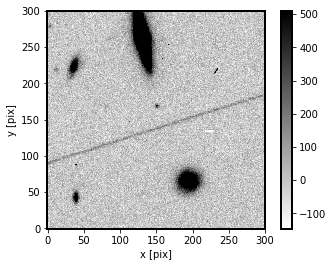

In [2]:
# load the image with astropy:
hdu = aif.open('data/track_demo.fits')
data = hdu[0].data

# obtain 'robust statistics' around the sky-background of the image:
data_mean, data_median, data_sigma = ast.sigma_clipped_stats(data[::10,::10])

# Clipping a sky-background dominated image at the following limits usually gives
# reasonable plotting results with 'imshow':
min_val = data_median - 3.0 * data_sigma
max_val = data_median + 10.0 * data_sigma

# note the origin option in the following command. Not giving it would put the
# image origin at the upper left corner instead of the lower-left. You can
# experiment with different colormaps than 'gray_r'; see for instance
# https://matplotlib.org/examples/color/colormaps_reference.html
plt.imshow(data, vmin=min_val, vmax=max_val, origin='lower', cmap='gray_r')
plt.colorbar()
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')

`SExtrator` performs the following essential steps to identify objects in optical images:
1. The sky-background is subtracted from the image. This step also estimates the sky-background variation $\sigma_\text{sky}$. After this step, the sky of the image has a mean of zero and a standard deviation of $\sigma_\text{sky}$.
2. The sky-subtracted image is smoothed to reduce the noise. This smoothed version of the image forms the basis for object identification.
3. All pixels in the smoothed image exceeding $k\times \sigma_\text{sky}$ are identified, where $k$ is a configurable parameter.
4. All connected pixel-groups from (3.) that consist of $n$ or more pixels are labelled as a source and analysed further. $n$ again is a configurable parameter. 

Of course this is a *very simplified* and incomplete description of the `SExtractor` procedures neglecting many important detail operations. In the following, we will not treat the background subtraction and the main focus of this notebook is on the steps 2-4. Note that we already estimated $\sigma_\text{sky}$ in a cell above (variable `data_sigma`).

## Image smoothing
Satellite tracks are long trails and most of them are quite faint. We therefore want to label pixel groups exceeding $1\times \sigma_\text{sky}$, i.e. $k=1$ as potential sources. After some trials, I found that a smoothing kernel of a Gaussian function with $\sigma_\text{Gauss}=1$ pixel gives good results for this task. Of course you should experiment with this and other free parameters for a concrete application.

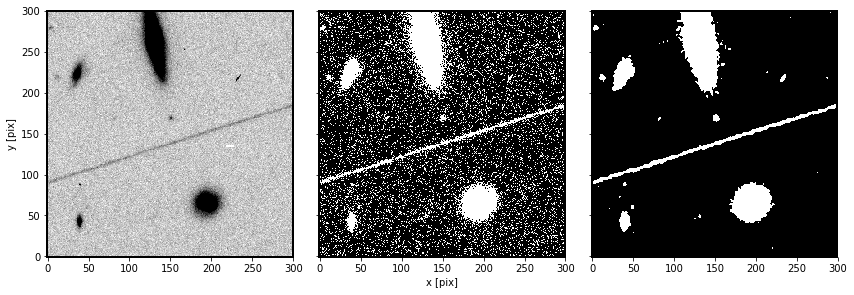

In [3]:
# demonstrate the effect of image smoothing on object detection

# pixels exceeding 1 \sigma_sky without any smoothing:
k = 1.0
det_nosmooth = data > k * data_sigma

# smooth data and determine pixels exceeding 1\sigma_sky
# after smoothing. The Gaussian-smoothing can be done
# with the gaussian_filter function from the scipy.ndimage.filters
# module:
sigma_gauss = 1.0
data_smooth = snf.gaussian_filter(data, sigma=sigma_gauss)
det_smooth = data_smooth > k * data_sigma

# plot original image and pixels exceeding \sigma_sky without
# and with smoothing:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax1.imshow(data, origin='lower', cmap='gray_r',
           vmin=min_val, vmax=max_val)
ax1.set_ylabel('y [pix]')
ax2.imshow(det_nosmooth, origin='lower', cmap='gray')
ax2.set_xlabel('x [pix]')
ax3.imshow(det_smooth, origin='lower', cmap='gray')
plt.tight_layout()

Left panel: original image; Middle panel: pixels exceeding $1\sigma_\text{sky}$ without Gaussian filtering; Right panel: pixels exceeding $1\sigma_\text{sky}$ after Gaussian filtering. 

**Notes:**
1. The image, which shows the pixels with a value larger than $k\times\sigma_\text{sky}$ *after* smoothing of the original image, is named *detection image* henceforth.
2. Note that the detection image is a two-dimensional `numpy`-array of type bool. If we apply operations such as summing over the pixels of a bool image the `False`-valued pixels are counted with 0 and the `True` pixels with 1.

## Object identification and analysis
<a id='after_segmentation'>

The object identification and analysis is done with functions of the `scipy.ndimage.measuremsnts`-module in the following steps:
- Connected pixel groups in the detection image are labelled (function `label`). This function creates a new `integer`-image which assigns an integer value to each group of connected pixels in the detction image.

63 connected features (potential sources) were found in the detection image


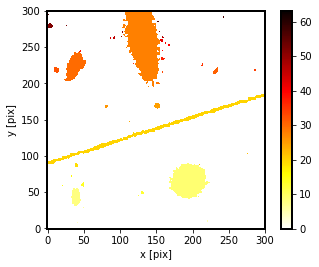

In [4]:
# label connected features in the smoothed detection image
objects, n_objects = snm.label(det_smooth)
print('{} connected features (potential sources) were found in the detection image'.format(n_objects))

plt.imshow(objects, origin='lower', cmap='hot_r')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')
plt.colorbar()

The plot demonstrates that the `label`-function assigns each pixel group in the detection image a separate integer value. `SExtractor` can provide this map as a `SEGMENTATION` checkimage. 

**Note:** An important step in the `SExtractor`-object-identification is *deblending*, i.e. to analyse whether a group of connected pixels originates from several, overlapping sources. We neglect this step in our model analysis. Please read section 7.4 of the [SExtractor manual](https://www.astromatic.net/pubsvn/software/sextractor/trunk/doc/sextractor.pdf) if you are interested in this subject. It would not be difficult to implement the SExtractor algorithm as part of our analysis.

- We can access individual sources via slicing-operations to the labelled image array. The slices themselfs are obtained with the `find_objects` function.

Text(0,0.5,'y [pix]')

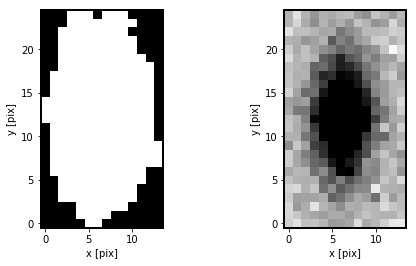

In [5]:
# obtain slices from the connected features (sources) identified with the label-method above.
# We pick the first object consisting of more than 30 pixels for a model analysis:
slices = snm.find_objects(objects)

# find the first object consisting of more than 30 pixels. We do this
# to have a well-resolved object for the following analysis:
req_pix = 30
n_pix = 0
i = 0
while (n_pix < req_pix):
    curr_object = objects[slices[i]]
    # we need the following line to reject pixels from other
    # sources that might overlap with our current source:
    curr_object = (curr_object == i + 1)
    n_pix = np.sum(curr_object)
    i = i + 1    
    
# plot the object in the original and the detection image    
i = i - 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(curr_object, origin='lower', cmap='gray')
ax1.set_xlabel('x [pix]')
ax1.set_ylabel('y [pix]')
ax2.imshow(data[slices[i]], origin='lower', cmap='gray_r',
           vmin=min_val, vmax=max_val)
ax2.set_xlabel('x [pix]')
ax2.set_ylabel('y [pix]')


Left panel: Pixels identified in the detection image belonging to our model object; Right panel: The original pixel values of the detected object

- We can now analyse the model object. A typical application is the estimation of quanitites such as the flux, the central position or higher-order moments of the light distribution.

In the following, the quantitity $I(\mathbf{x})$ be the intensity (flux) of an object at pixel-position $\mathbf{x} = (x, y)$. In the following code cell, we estimate the following quantities from our model source:

  1. $f=\int I(\mathbf{x})\, \text{d}\mathbf{x}$.
    This corresponds to *a measure of the flux* of the object. Note that the integral extends over all the pixels attributed to the object in the *smoothed detection image*. In `SExtractor`, this would correspond to the `FLUX_ISO` quantity. The actual estimation over the pixels is done by converting the integral to a pixel sum via:
    $$
    f=\int I(\mathbf{x})\, \text{d}\mathbf{x} \approx \sum_{(x, y)} I(x, y).
    $$
    The following integrals are treated accordingly.
    
    **Note:** There are *many* different possibilities to estimate the flux and corresponding magnitudes of objects. We consider here only *isophotal* flux estimates.
  2. $\bar{\mathbf{x}} = \frac 1f \int I(\mathbf{x})\mathbf{x}\, \text{d}\mathbf{x}$.
    This corresponds to the center of light and defines the object position.
  3. $c_{xx} = \frac 1f \int I(\mathbf{x})(x-\bar{x})^2\, \text{d}\mathbf{x}$,
    $c_{yy} = \frac 1f \int I(\mathbf{x})(y-\bar{y})^2\, \text{d}\mathbf{x}$ and
    $c_{xy} = \frac 1f \int I(\mathbf{x})(x-\bar{x})(y-\bar{y})\, \text{d}\mathbf{x}$. These are the second brightness moments of the object. We note that for an object *with the shape of an ellipse and constant surface brightness*, the semi-major and semi-minor axes of the object's ellipse can be estimated from the eigenvalues of the matrix
    $$
    C = \left(\begin{array}{cc} c_{xx} & c_{xy} \\ c_{xy} & c_{yy} \\ \end{array}\right).
    $$
    The angle $\varphi$ of the ellipse w.r.t. the coordinate frame can be obtained from the eigenvectors of $C$ or from the expression
    $$
    \varphi = \frac 12 \arctan\left(\frac{2 c_{xy}}{c_{xx}-c_{yy}}\right).
    $$
    
We can estimate all these quantities in a few lines of `Python`-code. Note especially the estimation of the various brightness moments. Each of them basically can be done in a single line of code using `numpy`-array-operations.

Text(0,0.5,'y [pix]')

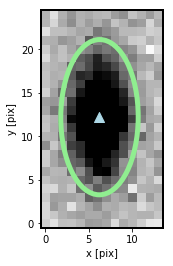

In [6]:
# note in the following that we are working in the coordinate frame
# of the object slice, not in that of the original image!

# preliminary data setup:
obj_det = curr_object
obj_data = data[slices[i]]
obj_pixels = obj_data * obj_det

slice_height, slice_width = obj_det.shape
x = np.arange(slice_width)
y = np.arange(slice_height)

# estimate (isophotal) flux
flux = np.sum(obj_pixels)

# estimate object center:
x_cen = np.sum(x[np.newaxis,:] * obj_pixels) / flux
y_cen = np.sum(y[:,np.newaxis] * obj_pixels) / flux

# estimate second order moments:
c_xx = np.sum(((x - x_cen)**2)[np.newaxis,:] * obj_pixels) / flux
c_yy = np.sum(((y - y_cen)**2)[:,np.newaxis] * obj_pixels) / flux
c_xy = np.sum((x - x_cen)[np.newaxis,:] *
              (y - y_cen)[:,np.newaxis] * obj_pixels) / flux

# We assume that our object can be well represented by an ellipse
# and we estimate the ellipse axes and its position angle:
C = np.array([[c_xx, c_xy], [c_xy, c_yy]])

# obtain the eigenvalues and eigenvectors of C and extract
# desired ellipse quantities:
w, v = sl.eig(C) # w: complex eigenvalues; v: eigenvectors

# ellipse axes (a: semi major axis; b: semi minor axis):
a, b = np.max(2.0 * np.sqrt(np.real(w))), np.min(2.0 * np.sqrt(np.real(w)))

# ellipse position angle:
phi = np.rad2deg(0.5 * np.arctan2(2.0 * c_xy, c_xx - c_yy))

# finally plot the object with its ellipse to verify what we have done:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# draw a triangle at object centre
plt.scatter([x_cen], [y_cen], s=100, marker="^", color='lightblue')
ax.imshow(data[slices[i]], origin='lower', cmap='gray_r',
          vmin=min_val, vmax=max_val)
ellipse = mp.Ellipse((x_cen, y_cen), 2.0 * a, 2.0 * b, angle=phi, linewidth=5,
                     edgecolor='lightgreen', fill=False)
ax.add_patch(ellipse)
ax.set_xlabel('x [pix]')
ax.set_ylabel('y [pix]')

The plot shows our model object with the central position (blue trangle) and the estimated ellipse parameters (green) overlaid.

## Satellite track detection
With the developed prescription to detect and to analyse objects in astronomical image we can now write down a recipe for the detction of satellite tracks. We do this as follows:

1. Create the detection image and candidate object lists as above. Note that for simplicity we entirely work on
the detection image and not on the original pixel values. This is sufficient for track detection.
2. Satellite tracks typically cross the complete observation and we only analyse objects with a large extent
3. We estimate ellipse parameters of the objects in (2) and label them as track if the ellipse semi-major axis $a$ is sufficiently large and if the ratio of semi-minor axis $b$ and semi-minor axis $a$ obeys $\frac ba < 0.1$.
4. If we found a track, we identifiy all pixels belonging to it from the detection image. To be sure that we catch all pixels belonging to the track, we extend the borders by a few pixels. This step is directly implemented in the `scipy.ndimage.morphology`-module 

**Note:** The following cell starts from the *SEGMENTATION* image creation [above](#after_segmentation).

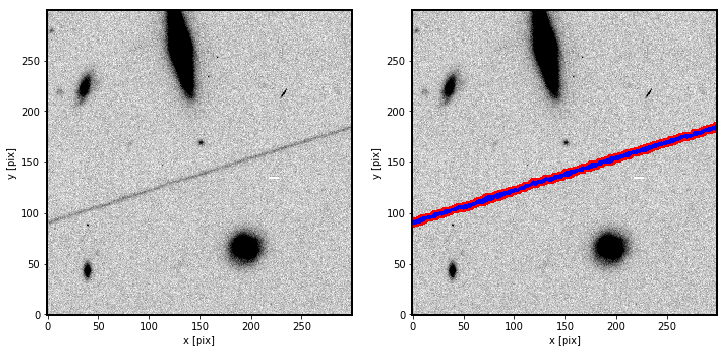

In [7]:
# this cell starts from the segmentation image 'objects' above
slices = snm.find_objects(objects)

track_pixels = np.zeros(objects.shape, bool)

# now check whether there are tracks among the objects:
for i, slc in enumerate(slices):
    # Note that we only work with the detection image, not on the original
    # pixel data here!
    det_pixels = objects[slc]
    
    # check whether the object has a significant size -
    # a necessary condition for a track:
    slice_height, slice_width = det_pixels.shape
    
    # The '300' is the width/height of the image
    if slice_height > 300 / np.sqrt(2.) or slice_width > 300 / np.sqrt(2.):
        det_pixels = (det_pixels == i + 1)
        x = np.arange(slice_width)
        y = np.arange(slice_height)
        flux = np.sum(det_pixels)
        x_cen = np.sum(x[np.newaxis,:] * det_pixels) / flux
        y_cen = np.sum(y[:,np.newaxis] * det_pixels) / flux
        c_xx = np.sum(((x - x_cen)**2)[np.newaxis,:] * det_pixels) / flux
        c_yy = np.sum(((y - y_cen)**2)[:,np.newaxis] * det_pixels) / flux
        c_xy = np.sum((x - x_cen)[np.newaxis,:] *
                      (y - y_cen)[:,np.newaxis] * det_pixels) / flux
        C = np.array([[c_xx, c_xy], [c_xy, c_yy]])
        w, v = sl.eig(C)
        a, b = np.max(2.0 * np.sqrt(np.real(w))), \
               np.min(2.0 * np.sqrt(np.real(w)))
        
        # The final check whether we have a track:
        if a > (300 / (2. * np.sqrt(2.))) and b / a < 0.1:
            track_pixels[slc] = det_pixels
            
# make a plot from the original image and track pixels if track(s) were found:
if np.sum(track_pixels) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(data, origin='lower', cmap='gray_r',
              vmin=min_val, vmax=max_val)
    ax1.set_xlabel('x [pix]')
    ax1.set_ylabel('y [pix]')
    ax2.imshow(data, origin='lower', cmap='gray_r',
              vmin=min_val, vmax=max_val)
    # dilate the track by 5 pixels on its borders pixels to be sure to catch
    # also faint pixels belonging to it
    track_image = np.zeros(track_pixels.shape + (4,), np.uint8)
    newtrack_pixels = snmo.binary_dilation(track_pixels,
                                           structure=np.ones((5,5)))
    diff = newtrack_pixels ^ track_pixels
    track_image[:,:,2] = (track_pixels > 0) * 255
    track_image[:,:,3] = (newtrack_pixels > 0) * 255
    track_image[:,:,0] = (diff > 0) * 255
    ax2.imshow(track_image, origin='lower')
    ax2.set_xlabel('x [pix]')
    ax2.set_ylabel('y [pix]')

Left: original data; Right: Pixels attributed to the track by the original detection (blue). In red, we show the track border-dilation to catch also faint pixels.

Please find [here](code/scipy_track_detection.py) a stand-alone script performing satellite track detection in an astronomical image.

## Software versions
Here are the Python and module versions I used to create this notebook
**Note:**
If the following cell produces an error message for you, you need to install the [`version_information` module](https://github.com/jrjohansson/version_information). Possibilities to do so include:
1. `conda install -c conda-forge version_information` if you work with the `Anaconda`-Python-distribution.
2. `pip install version_infromation`

In [8]:
%reload_ext version_information
%version_information scipy, astropy, matplotlib

Software versions
Python 3.6.6 64bit [GCC 7.2.0]
IPython 6.5.0
OS Linux 3.13.0 158 generic x86_64 with debian jessie sid
scipy 1.1.0
astropy 3.0.4
matplotlib 2.2.3
Wed Sep 19 22:52:30 2018 CEST